## **Forecasting Economic Indicators with Multivariate Time Series Models**

## Dataset Overview

The Global Economy dataset provides a comprehensive overview of key economic indicators across countries and regions over an extended time period. This dataset captures annual data from a wide range of nations, enabling cross-country comparisons and trend analysis from a macroeconomic perspective.

The dataset includes essential variables such as GDP, population, employment rate, inflation, and region, making it a valuable resource for economic analysis, policy evaluation, and forecasting. With data spanning multiple decades and covering both developed and developing countries, it supports deep explorations into global growth patterns, regional disparities, and long-term economic trends.

For this project, I will be selecting specific economic areas and applying various time series techniques to analyze and model their economic performance over time.

[Dataset Link](https://github.com/NowanIlfideme/tsdata)

## **Data Inspection and Preparation**

First, let's dedicate one cell to importation of requirements we will be using throughout the project

In [6]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.tools.sm_exceptions as sm_exceptions
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw

from tsdata.raw import available_data, load_data

In [7]:
df = load_data("global_economy")

In [8]:
df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0
2,Afghanistan,AFG,1962,5.466667e+08,NaN,NaN,9.349593,4.878051,9345868.0
3,Afghanistan,AFG,1963,7.511112e+08,NaN,NaN,16.863910,9.171601,9533954.0
4,Afghanistan,AFG,1964,8.000000e+08,NaN,NaN,18.055555,8.888893,9731361.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     15150 non-null  object 
 1   Code        15150 non-null  object 
 2   Year        15150 non-null  int64  
 3   GDP         11828 non-null  float64
 4   Growth      11394 non-null  float64
 5   CPI         7670 non-null   float64
 6   Imports     10596 non-null  float64
 7   Exports     10587 non-null  float64
 8   Population  15147 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.0+ MB


In [10]:
null_counts_by_country = df.drop(columns='Country').groupby(df['Country']).apply(lambda x: x.isnull().sum().sum())
null_counts_by_country.sort_values()

Country
South Africa                   1
Canada                         1
Spain                          1
Colombia                       1
Costa Rica                     1
                            ... 
British Virgin Islands       290
St. Martin (French part)     290
Korea, Dem. People's Rep.    290
Gibraltar                    290
Turks and Caicos Islands     290
Length: 263, dtype: int64

In [11]:
belgium = df[df['Country'] == 'Belgium'].copy()
belgium.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
1102,Belgium,BEL,1960,1.165872e+10,NaN,15.596081,38.500674,37.800692,9153489.0
1103,Belgium,BEL,1961,1.240015e+10,4.978423,15.750900,39.805297,39.013175,9183948.0
1104,Belgium,BEL,1962,1.326402e+10,5.212004,15.972138,40.584552,40.573091,9220578.0
1105,Belgium,BEL,1963,1.426002e+10,4.351584,16.315220,42.670045,41.712539,9289770.0
1106,Belgium,BEL,1964,1.596011e+10,6.956685,16.995363,42.829324,42.497554,9378113.0


In [12]:
belgium.sort_values('Year', inplace=True)
belgium.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
1102,Belgium,BEL,1960,1.165872e+10,NaN,15.596081,38.500674,37.800692,9153489.0
1103,Belgium,BEL,1961,1.240015e+10,4.978423,15.750900,39.805297,39.013175,9183948.0
1104,Belgium,BEL,1962,1.326402e+10,5.212004,15.972138,40.584552,40.573091,9220578.0
1105,Belgium,BEL,1963,1.426002e+10,4.351584,16.315220,42.670045,41.712539,9289770.0
1106,Belgium,BEL,1964,1.596011e+10,6.956685,16.995363,42.829324,42.497554,9378113.0


So we chose the belgium as our country, because it has the most quality data in terms of null values, it has one of the least amount of null values in their variables, it has only 1, and that 1 is in growth column, because you cant know the growth in the first year, because it need the previous year to calculate the growth so it is not even a missing value. Now before building dynamic regression for belgium, lets preprocess our data appropriately

In [14]:
belgium.set_index('Year', inplace=True)
belgium.drop(columns=['Code'], inplace=True)

In [15]:
belgium.head()

,Country,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,
1960,Belgium,1.165872e+10,NaN,15.596081,38.500674,37.800692,9153489.0
1961,Belgium,1.240015e+10,4.978423,15.750900,39.805297,39.013175,9183948.0
1962,Belgium,1.326402e+10,5.212004,15.972138,40.584552,40.573091,9220578.0
1963,Belgium,1.426002e+10,4.351584,16.315220,42.670045,41.712539,9289770.0
1964,Belgium,1.596011e+10,6.956685,16.995363,42.829324,42.497554,9378113.0


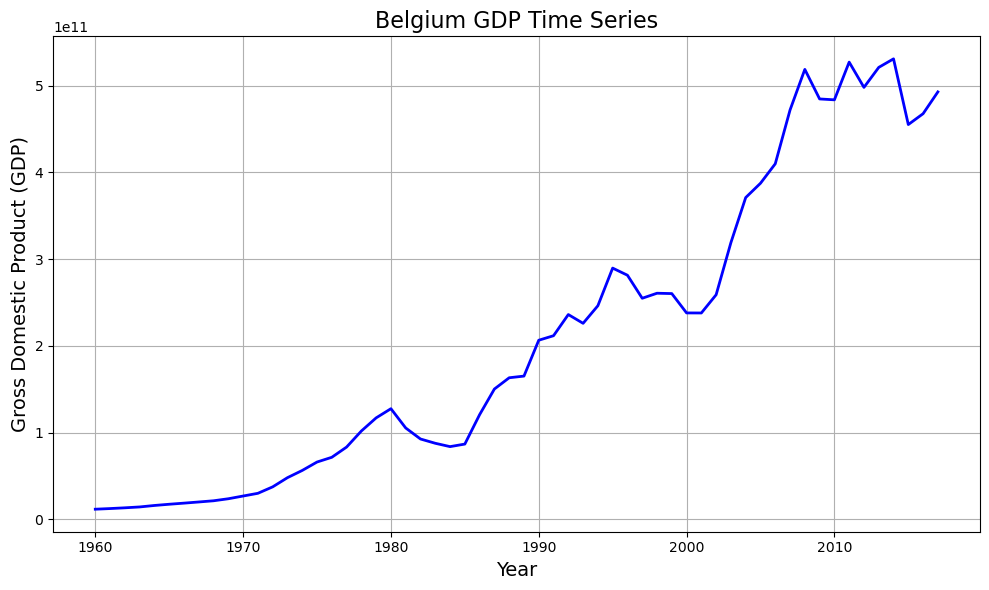

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(belgium.index, belgium['GDP'], label='GDP', color='blue', lw=2)

plt.title('Belgium GDP Time Series', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gross Domestic Product (GDP)', fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
adf_result = adfuller(belgium['GDP'], autolag='AIC')

adf_output = pd.Series(adf_result[0:4],
                       index=["ADF Test Statistic", "p-value", "# Lags Used", "# Observations Used"])

for key, value in adf_result[4].items():
    adf_output[f"Critical Value ({key})"] = value

print(adf_output)

ADF Test Statistic       1.852306
p-value                  0.998447
# Lags Used             11.000000
# Observations Used     46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
dtype: float64


our test statistic is greater than the critical values for all significance levels, and p values is also very high and much higher than 0.05, which makes our GPD time series non-stationary. Dynamic Regression's mainc requirement is to have stationary time series for target variable, exogenous variables could stay as they are, so we can make our GDP stationary by first-order differencing, which turns out to be the most used method for GDP, due to its exponential long term growth

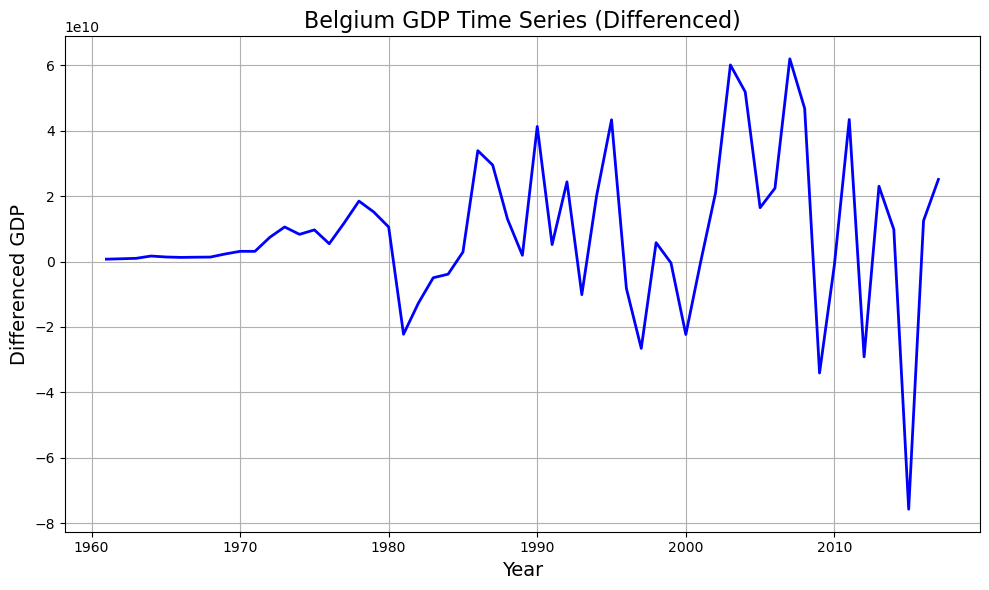

In [19]:
belgium['GDP'] = belgium['GDP'] - belgium['GDP'].shift(1)

plt.figure(figsize=(10, 6))
plt.plot(belgium.index, belgium['GDP'], label='Differenced GDP', color='blue', lw=2)

plt.title('Belgium GDP Time Series (Differenced)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Differenced GDP', fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
result_diff = adfuller(belgium['GDP'].dropna())
print(f'ADF Statistic: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')
if result_diff[1] < 0.05:
    print("The differenced GDP is stationary.")
else:
    print("The differenced GDP is still non-stationary.")

ADF Statistic: -3.3959190130917505
p-value: 0.011098781378869521
The differenced GDP is stationary.


In [21]:
belgium.head()

,Country,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,
1960,Belgium,NaN,NaN,15.596081,38.500674,37.800692,9153489.0
1961,Belgium,7.414226e+08,4.978423,15.750900,39.805297,39.013175,9183948.0
1962,Belgium,8.638705e+08,5.212004,15.972138,40.584552,40.573091,9220578.0
1963,Belgium,9.960017e+08,4.351584,16.315220,42.670045,41.712539,9289770.0
1964,Belgium,1.700089e+09,6.956685,16.995363,42.829324,42.497554,9378113.0


In [22]:
belgium = belgium.iloc[3:]
belgium.head()

,Country,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,
1963,Belgium,9.960017e+08,4.351584,16.315220,42.670045,41.712539,9289770.0
1964,Belgium,1.700089e+09,6.956685,16.995363,42.829324,42.497554,9378113.0
1965,Belgium,1.411351e+09,3.560660,17.686258,42.006798,41.983271,9463667.0
1966,Belgium,1.280426e+09,3.155895,18.424544,44.369640,43.666105,9527807.0
1967,Belgium,1.340157e+09,3.868147,18.927590,42.267561,42.686732,9580991.0


Okay since we have the perfectly ready dataset, now we can do ARIMAX dynamic regression, using GPD as our tager variable ARIMA as the date pattern and all the other economic columns as exogenous predictors

## ARIMAX

In [24]:
train_size = int(0.8 * len(belgium))
train_data = belgium.iloc[:train_size]
test_data = belgium.iloc[train_size:]

In [25]:
y_train = train_data['GDP']
y_test = test_data['GDP']
exog_train = train_data[['Growth', 'CPI', 'Imports', 'Exports', 'Population']]
exog_test = test_data[['Growth', 'CPI', 'Imports', 'Exports', 'Population']]

In [26]:
warnings.filterwarnings("ignore")

p, d, q = 1, 1, 1

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(p, d, q),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   44
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1023.741
Date:                Fri, 09 May 2025   AIC                           2063.481
Time:                        15:40:51   BIC                           2077.190
Sample:                             0   HQIC                          2068.473
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Growth      1.669e+09      0.144   1.16e+10      0.000    1.67e+09    1.67e+09
CPI         7.069e+08      0.979   7.22e+08      0.000    7.07e+08    7.07e+08
Imports    -2.669e+09      0.046  -5.76e+10      0.0

In [27]:
forecast = results.predict(
    start=len(train_data),
    end=len(belgium)-1,
    exog=exog_test,
    dynamic=True
)

forecast.head()

44    1.958198e+10
45    4.364971e+09
46    3.005154e+10
47    2.305919e+10
48    1.058411e+10
Name: predicted_mean, dtype: float64

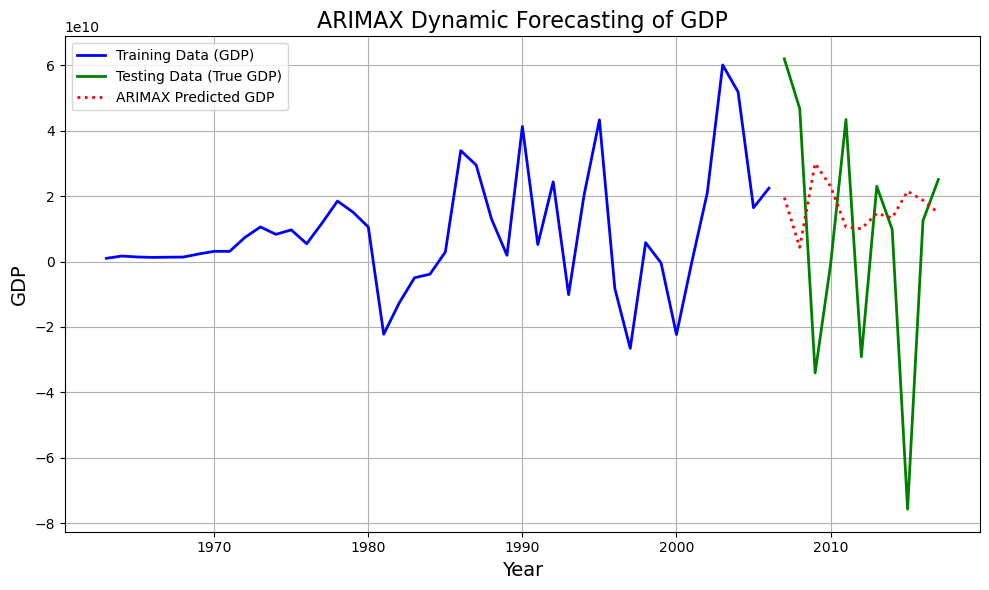

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(train_data.index, y_train, label='Training Data (GDP)', color='blue', lw=2)

plt.plot(test_data.index, y_test, label='Testing Data (True GDP)', color='green', lw=2)

plt.plot(test_data.index, forecast, label='ARIMAX Predicted GDP', color='red', linestyle=':', lw=2)

plt.title('ARIMAX Dynamic Forecasting of GDP', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('GDP', fontsize=14)

plt.legend(loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def evaluate_model(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }
metrics = evaluate_model(y_test, forecast)
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.2f}")

Root Mean Squared Error (RMSE): 43268101601.31
Mean Absolute Error (MAE): 33699493381.56


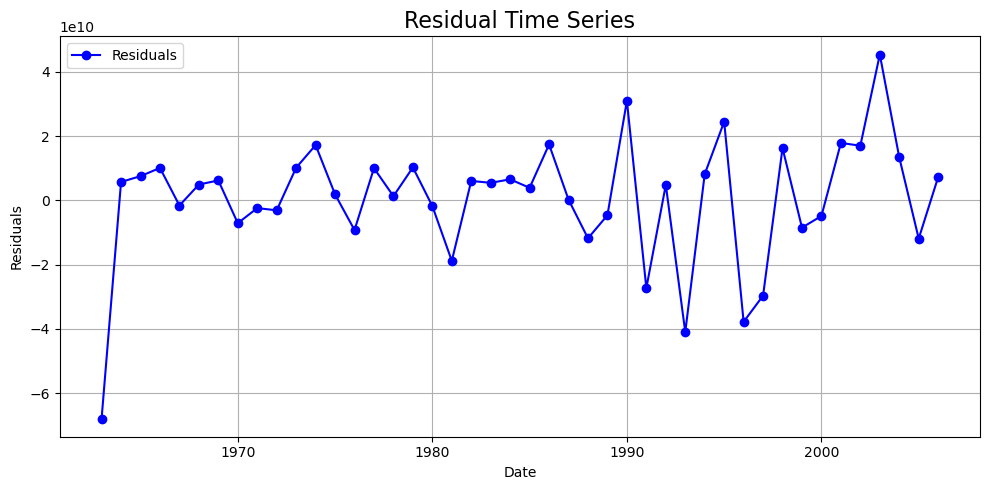

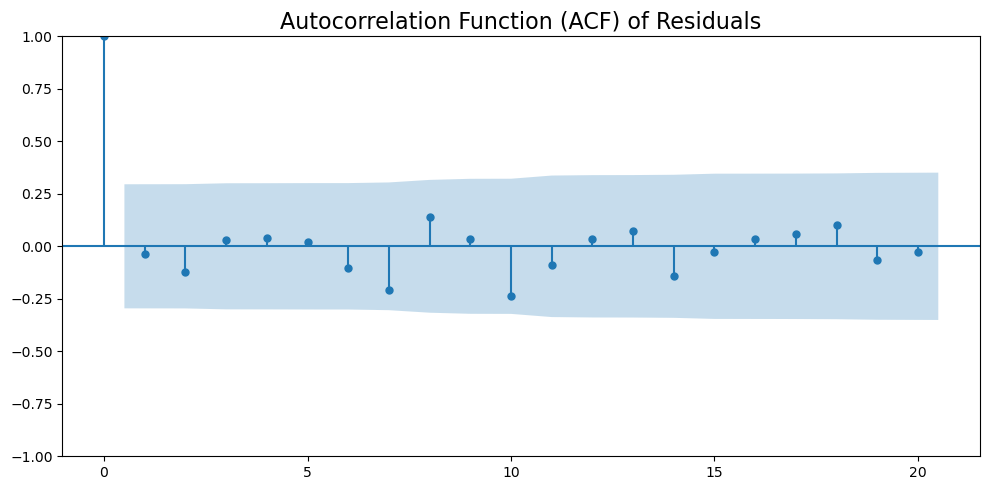

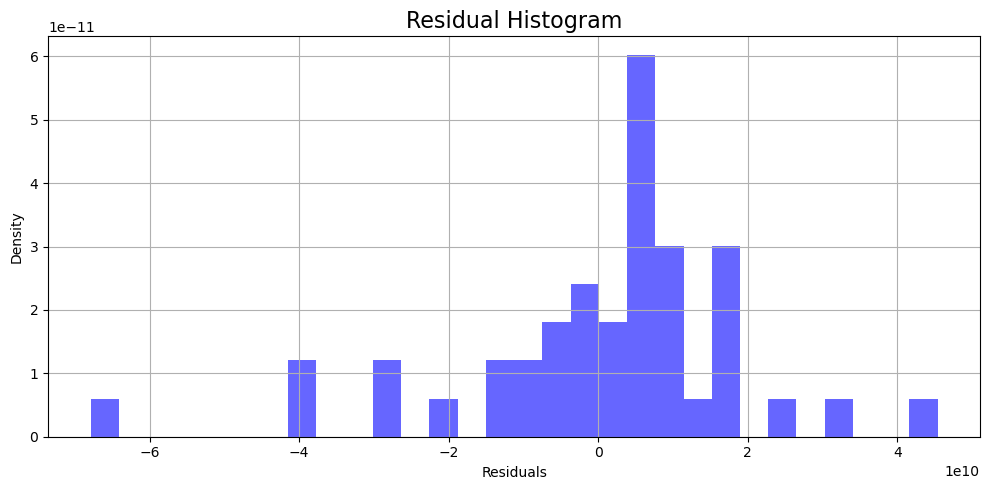

In [30]:
def plot_residual_series(residuals):
    plt.figure(figsize=(10, 5))
    plt.plot(residuals.index, residuals, label='Residuals', marker='o', linestyle='-', color='blue')
    plt.title('Residual Time Series', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_acf(residuals, lags=20):
    plt.figure(figsize=(10, 5))
    plot_acf(residuals, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF) of Residuals', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(residuals):
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=30, density=True, color='blue', alpha=0.6)
    plt.title('Residual Histogram', fontsize=16)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
residuals = results.resid

plot_residual_series(residuals)
plot_residual_acf(residuals)
plot_residual_distribution(residuals)

Lets now conclude all our results of ARIMAX model and evaluate its performance based on residuals, evaluation metrics and model summary: About the metrics, 42B RMSE indicates large overall errors in predictions, as well as high MAE (33B), both suggesting significant deviations. Model Summary tells us that all the economic exogenous variables have meaningfull contribution and affect on our GDP forecast, but we cant say the same about the population since its high p value. Our moving average term is significant, capturing residual correlations effectively, but the autoregressive term is weakly influencing past GDP values. Our residulas time series plot shows model's under specification, while ACF plot suggest a succesful lag dependencies, however the significant spike at lag 1 indicates strong autocorrelations remain. Histogram is not normal, which is also evidenced by jarque-bera test, with high p value

Lets now move on to the next model, which is Facebook Prophet and see how it performs. Unlike the first task, I want to use the Prophet's ability to add external regressors, so I will add Growth, CPI, Imports and Exports as exogneous variables for improved forecasting

## Facebook Prophet

In [33]:
df = load_data("global_economy")
belgium = df[df['Country'] == 'Belgium'].copy()
belgium.sort_values('Year', inplace=True)
belgium.drop(columns=['Code'], inplace=True)
belgium.drop(columns=['Population'], inplace=True)
belgium.drop(columns=['Country'], inplace=True)
belgium = belgium.rename(columns={"Year": "ds", "GDP": "y"})
belgium = belgium.iloc[1:]
belgium.tail()

,ds,y,Growth,CPI,Imports,Exports
1155,2013,5.209255e+11,0.200650,107.657181,80.488342,81.730301
1156,2014,5.307710e+11,1.293265,108.023218,82.037947,82.672055
1157,2015,4.550396e+11,1.426957,108.629692,79.434961,80.794364
1158,2016,4.675455e+11,1.412292,110.773882,81.606927,82.937776
1159,2017,4.926813e+11,1.729767,113.128903,84.349415,85.053297


In [34]:
train_size = int(0.8 * len(belgium))
train_data = belgium.iloc[:train_size]
test_data = belgium.iloc[train_size:]

In [35]:
model = Prophet()

model.add_regressor('Growth')
model.add_regressor('CPI')
model.add_regressor('Imports')
model.add_regressor('Exports')

warnings.filterwarnings("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

model.fit(train_data)

future = test_data[['ds', 'Growth', 'CPI', 'Imports', 'Exports']]
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2006-01-01,3.257847e+11,2.995328e+11,3.523364e+11
1,2007-01-01,3.351348e+11,3.106987e+11,3.599741e+11
2,2008-01-01,3.444699e+11,3.210259e+11,3.708195e+11
3,2009-01-01,3.870305e+11,3.620968e+11,4.136473e+11
4,2010-01-01,3.896641e+11,3.648800e+11,4.147543e+11
5,2011-01-01,3.821252e+11,3.557785e+11,4.070355e+11
6,2012-01-01,3.893183e+11,3.626297e+11,4.132646e+11
7,2013-01-01,4.025545e+11,3.773841e+11,4.271317e+11
8,2014-01-01,4.156270e+11,3.908213e+11,4.389323e+11
9,2015-01-01,4.352697e+11,4.109482e+11,4.621476e+11


In [36]:
test_data['ds'] = pd.to_datetime(test_data['ds'], format='%Y')

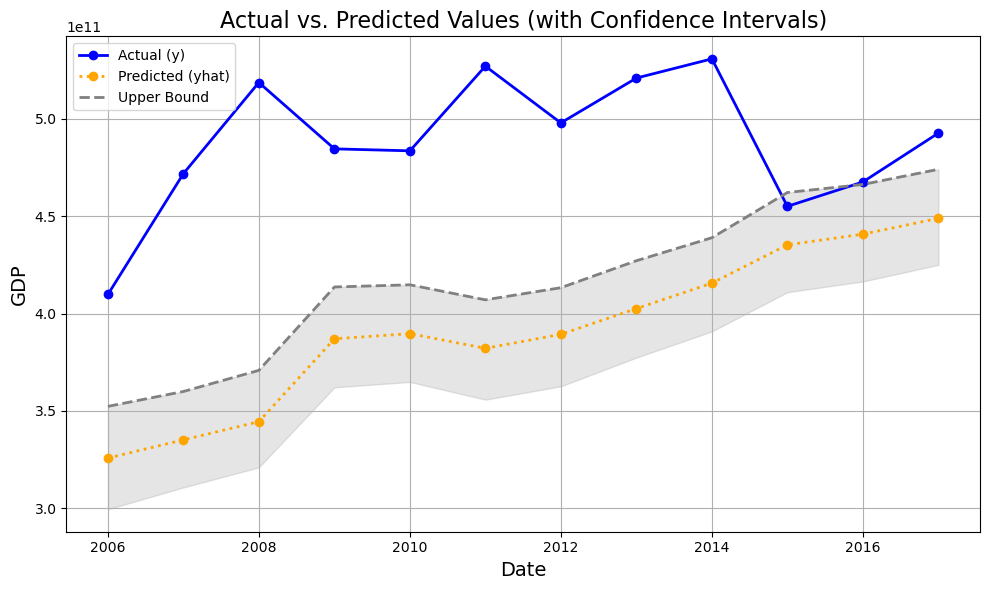

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(test_data['ds'], test_data['y'], label='Actual (y)', color='blue', marker='o', markersize=6, linestyle='-', lw=2)

plt.plot(forecast['ds'], forecast['yhat'], label='Predicted (yhat)', color='orange', linestyle=':', marker='o', markersize=6, lw=2)

plt.plot(forecast['ds'], forecast['yhat_upper'], label='Upper Bound', color='gray', linestyle='--', lw=2)

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

plt.title('Actual vs. Predicted Values (with Confidence Intervals)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('GDP', fontsize=14)

plt.legend(loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
y_test = test_data['y'].values
y_pred = forecast['yhat'].values

metrics = evaluate_model(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")

Root Mean Squared Error (RMSE): 107033470283.25
Mean Absolute Error (MAE): 96967843197.57
Mean Absolute Percentage Error (MAPE): 19.61%


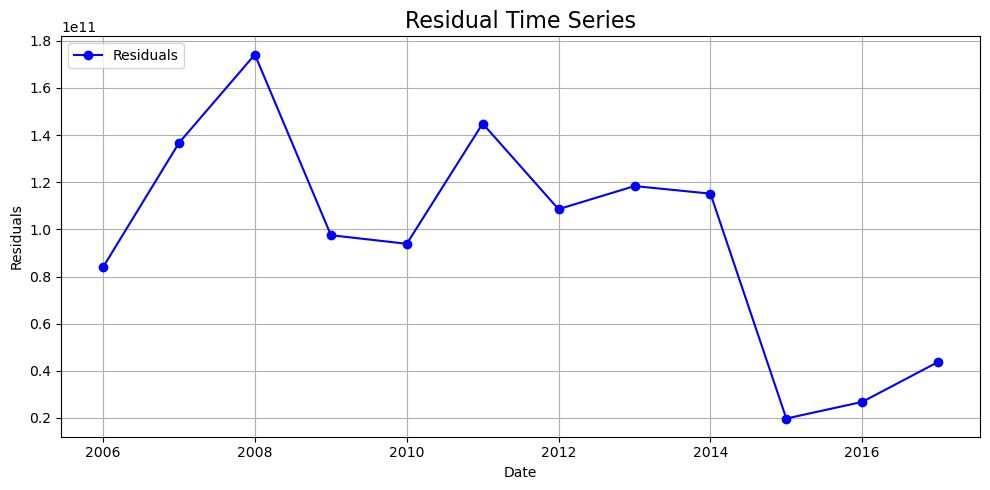

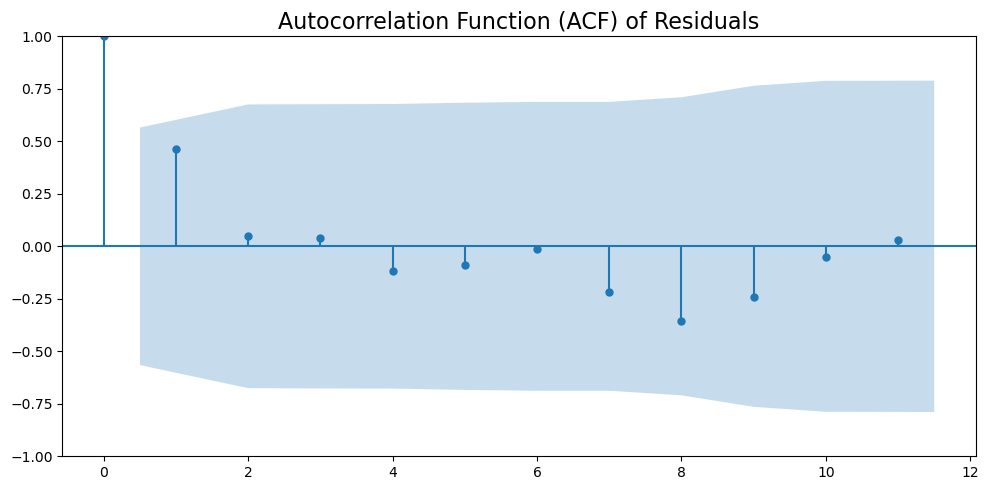

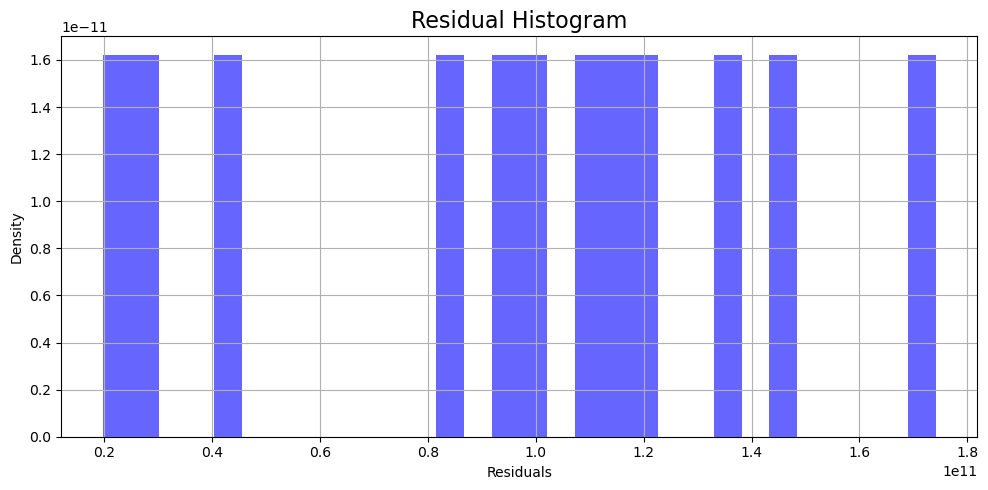

In [39]:
def plot_residual_acf_v2(residuals, lags=20):
    lags = min(lags, len(residuals) - 1)
    
    plt.figure(figsize=(10, 5))
    plot_acf(residuals, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF) of Residuals', fontsize=16)
    plt.tight_layout()
    plt.show()
    
residuals = pd.Series(y_test - y_pred, index=test_data['ds'])
plot_residual_series(residuals)
plot_residual_acf_v2(residuals)
plot_residual_distribution(residuals)

Time to do the prophet performance evaluation overview: So RMSE shows high variance in the residuals, which suggest poor model, as well as MAE which also observes large error magnitudes. MAPE shows approximatel 19% error, which could be expectable in some cases, but it depends. What can be said about residuals, they show clear temporal patterns rather than random distribution, especially during 2008-2012 and over predictions around 2014-2015. ACF plot revelas significant autocorrelation at lag 1, indicating unaddressed dependencies and potential model under specification. And finally the histogram shows high skewness and wide error spread, which means systematic bias in predictions

Now it is time for our final model - VAR. For VAR we have to choose the countries that have the most similar economic profiles for the logical correlation between then, so we yield the logical and precise forecasts

One way to find out some pattern between GPDs I will plot pearson's correlation plot for better insights

## VAR

In [43]:
df = load_data("global_economy")
df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0
2,Afghanistan,AFG,1962,5.466667e+08,NaN,NaN,9.349593,4.878051,9345868.0
3,Afghanistan,AFG,1963,7.511112e+08,NaN,NaN,16.863910,9.171601,9533954.0
4,Afghanistan,AFG,1964,8.000000e+08,NaN,NaN,18.055555,8.888893,9731361.0


In [44]:
null_counts_by_country = df.groupby('Country').apply(lambda x: x.isnull().sum().sum())

top_50_countries = null_counts_by_country.sort_values(ascending=True).head(50).index

filtered_df = df[df['Country'].isin(top_50_countries)]

gdp_pivot = filtered_df.pivot_table(index='Year', columns='Country', values='GDP')

correlation_matrix = gdp_pivot.corr()

correlation_pairs = correlation_matrix.unstack().drop_duplicates()
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

sorted_correlation_pairs = correlation_pairs.sort_values(ascending=False)

top_10_correlated_countries = sorted_correlation_pairs.head(10)

print(top_10_correlated_countries)

Country     Country    
Austria     Belgium        0.999142
Belgium     Denmark        0.999082
Austria     Denmark        0.999020
Denmark     France         0.998820
            Netherlands    0.998615
Belgium     France         0.998161
Austria     France         0.998076
Belgium     Netherlands    0.997861
Costa Rica  Philippines    0.997066
Austria     Netherlands    0.996848
dtype: float64


So pretty logically the highest correlated GDP are in the neighboar countries from europe, so I will take Belgium, Austria, and France for VAR model and we will see how this decision turns out

In [46]:
selected_countries = ['Belgium', 'Austria', 'France']
df = df[df['Country'].isin(selected_countries)]
df = df.pivot_table(index='Year', columns='Country', values='GDP')
df.head()

Country,Austria,Belgium,France
Year,,,
1960,6.592694e+09,1.165872e+10,6.265147e+10
1961,7.311750e+09,1.240015e+10,6.834674e+10
1962,7.756110e+09,1.326402e+10,7.631378e+10
1963,8.374175e+09,1.426002e+10,8.555111e+10
1964,9.169984e+09,1.596011e+10,9.490659e+10


Since VAR requires stationarity in the series, we have to check it for for all the countries

In [48]:
def stationarity_check(data):
    stationary_data = data.copy()
    for col in stationary_data.columns:
        result = adfuller(stationary_data[col])
        print(f"ADF Statistic for {col}: {result[0]}")
        print(f"p-value for {col}: {result[1]}")
        if result[1] > 0.05:
            print(f"{col} is not stationary. Differencing will be applied.")
            stationary_data[col] = stationary_data[col].diff().dropna()
        else:
            print(f"{col} is stationary.")
    return stationary_data

df = stationarity_check(df)

df.dropna(inplace=True)
df.head()

ADF Statistic for Austria: 1.716209866162775
p-value for Austria: 0.998167513110062
Austria is not stationary. Differencing will be applied.
ADF Statistic for Belgium: 1.8523062966146144
p-value for Belgium: 0.9984473060606996
Belgium is not stationary. Differencing will be applied.
ADF Statistic for France: -0.7659403655185772
p-value for France: 0.8289227132600436
France is not stationary. Differencing will be applied.


Country,Austria,Belgium,France
Year,,,
1961,7.190558e+08,7.414226e+08,5.695267e+09
1962,4.443606e+08,8.638705e+08,7.967041e+09
1963,6.180650e+08,9.960017e+08,9.237332e+09
1964,7.958086e+08,1.700089e+09,9.355480e+09
1965,8.240867e+08,1.411351e+09,7.253978e+09


In [49]:
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [50]:
model = VAR(train_data)

lag_choice = model.select_order()
print("Optimal lag order based on criteria:", lag_choice.selected_orders)
lags = lag_choice.aic
print(f"Number of lags chosen: {lags}")

var_model = model.fit(lags)

print(var_model.summary())

Optimal lag order based on criteria: {'aic': 10, 'bic': 10, 'hqic': 10, 'fpe': 10}
Number of lags chosen: 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, May, 2025
Time:                     15:40:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    136.523
Nobs:                     35.0000    HQIC:                   133.816
Log likelihood:          -2372.81    FPE:                6.92826e+58
AIC:                      132.390    Det(Omega_mle):     1.03323e+58
--------------------------------------------------------------------
Results for equation Austria
                   coefficient         std. error           t-stat            prob
----------------------------------------------------------------------------------
const        6842794857.479607  3979623739.161640            1.719           0.086
L1.Austria           -2.

In [51]:
forecast_steps = len(test_data)
forecast = var_model.forecast(train_data.values, steps=forecast_steps)

forecast_index = test_data.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=train_data.columns)

print("Generated forecasts:")
print(forecast_df)


Generated forecasts:
Country       Austria       Belgium        France
Year                                             
2006    -2.959683e+10 -7.386914e+09 -1.905770e+11
2007     2.180631e+11  2.954145e+11  1.602103e+12
2008    -3.645960e+10 -2.725180e+10 -2.025955e+11
2009     8.366649e+09  3.517526e+10  2.625832e+11
2010     4.257815e+09 -4.635286e+10 -2.004439e+11
2011     8.882235e+10  6.978108e+10  6.268342e+11
2012    -1.554789e+11 -2.208144e+11 -1.314290e+12
2013     4.265050e+10 -1.273784e+10  3.273482e+11
2014    -2.820533e+11 -3.935451e+11 -2.322306e+12
2015     2.037040e+11  2.513021e+11  1.469654e+12
2016     6.511564e+09  1.976618e+10 -1.516004e+11
2017     4.093059e+10  1.102443e+11  9.157149e+11


In [52]:
for col in test_data.columns:
    actual = test_data[col]
    forecasted = forecast_df[col]

    mae = mean_absolute_error(actual, forecasted)

    rmse = np.sqrt(mean_squared_error(actual, forecasted))

    print(f"Evaluation for {col}:")
    print(f"  - MAE: {mae}")
    print(f"  - RMSE: {rmse}")

Evaluation for Austria:
  - MAE: 93684690813.34389
  - RMSE: 133673167757.4296
Evaluation for Belgium:
  - MAE: 127373063880.15703
  - RMSE: 178744226294.72168
Evaluation for France:
  - MAE: 804382294126.3154
  - RMSE: 1059683344334.2688


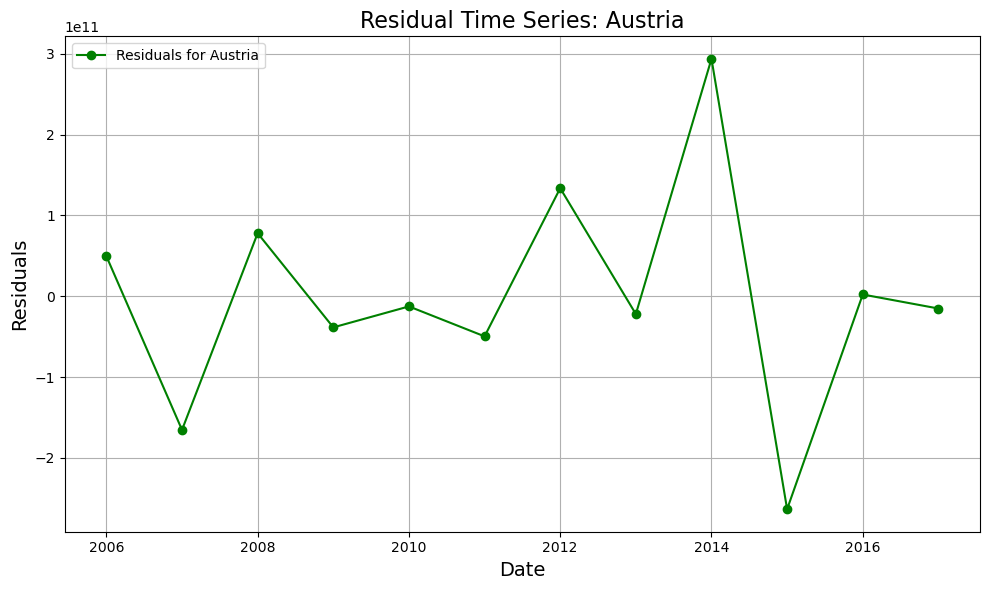

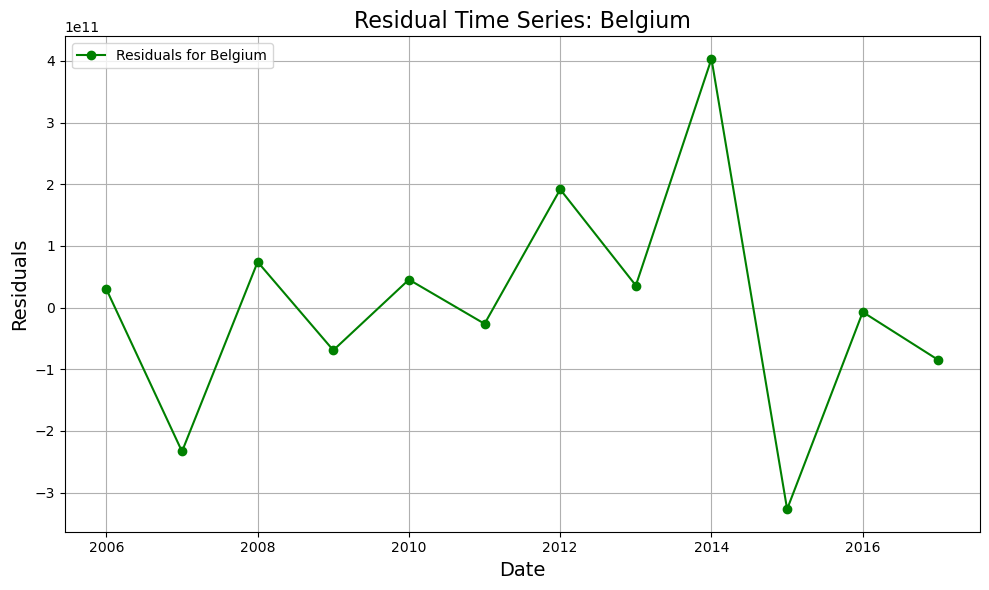

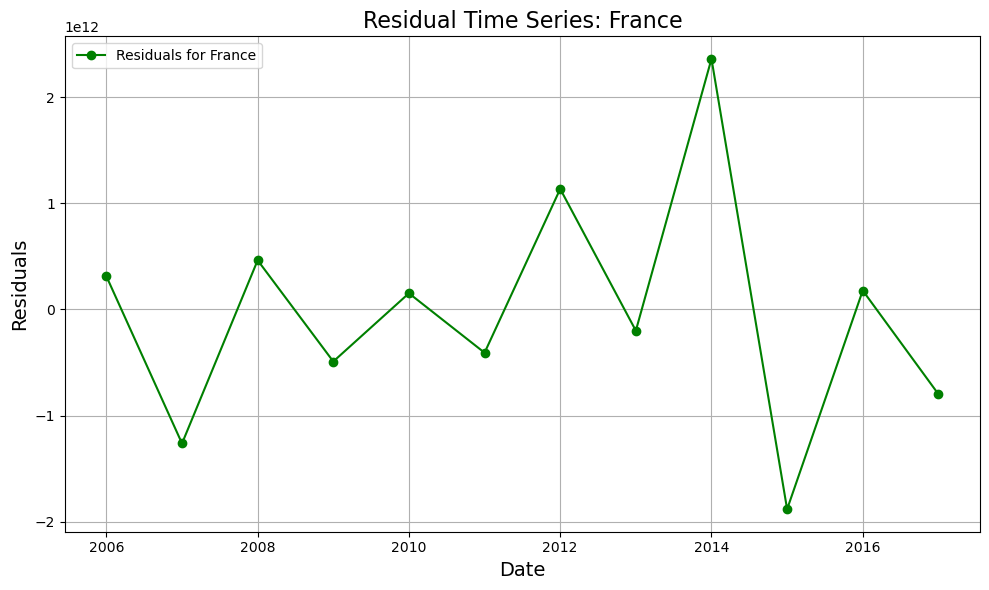

<Figure size 1000x600 with 0 Axes>

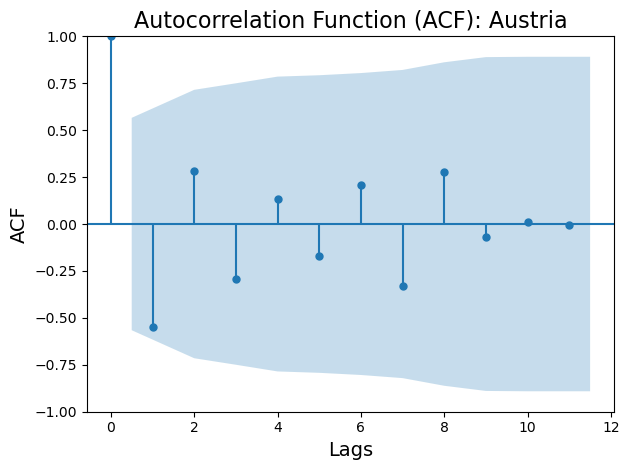

<Figure size 1000x600 with 0 Axes>

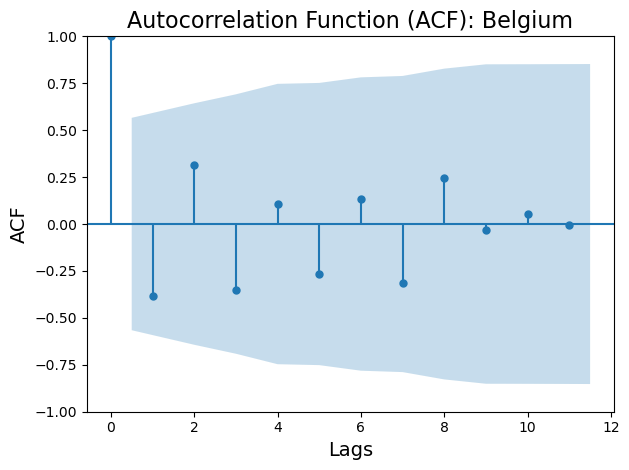

<Figure size 1000x600 with 0 Axes>

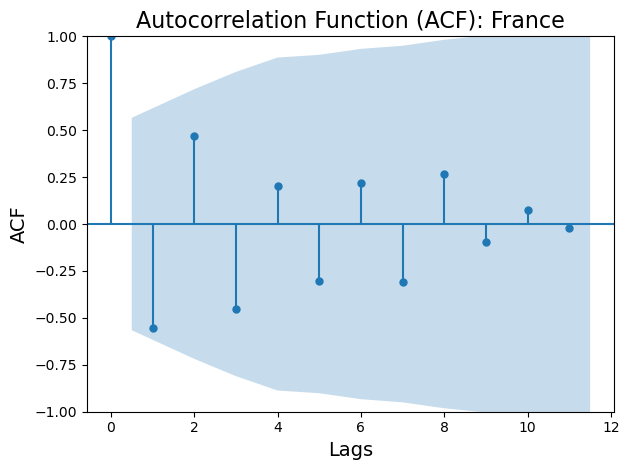

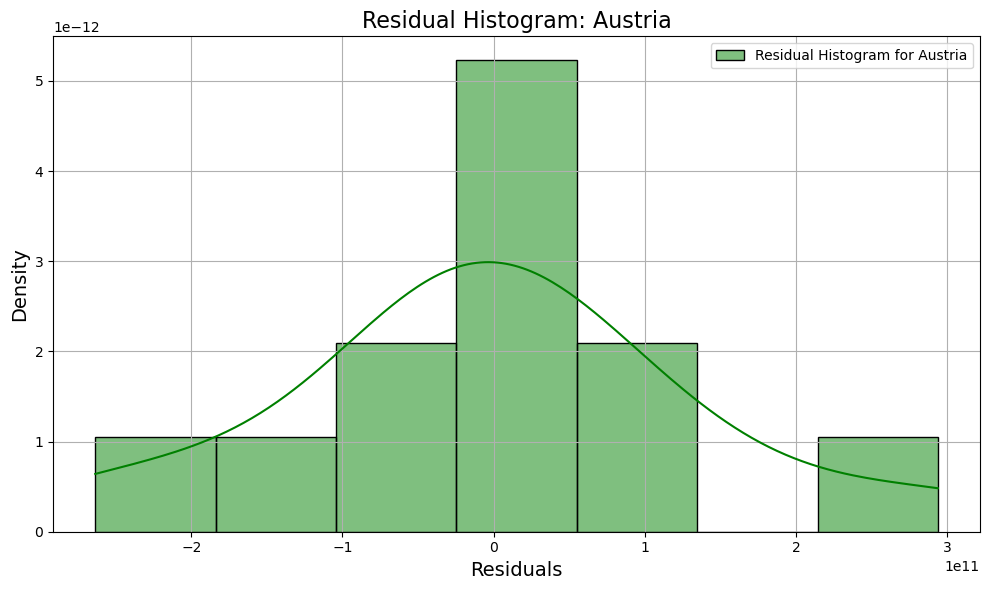

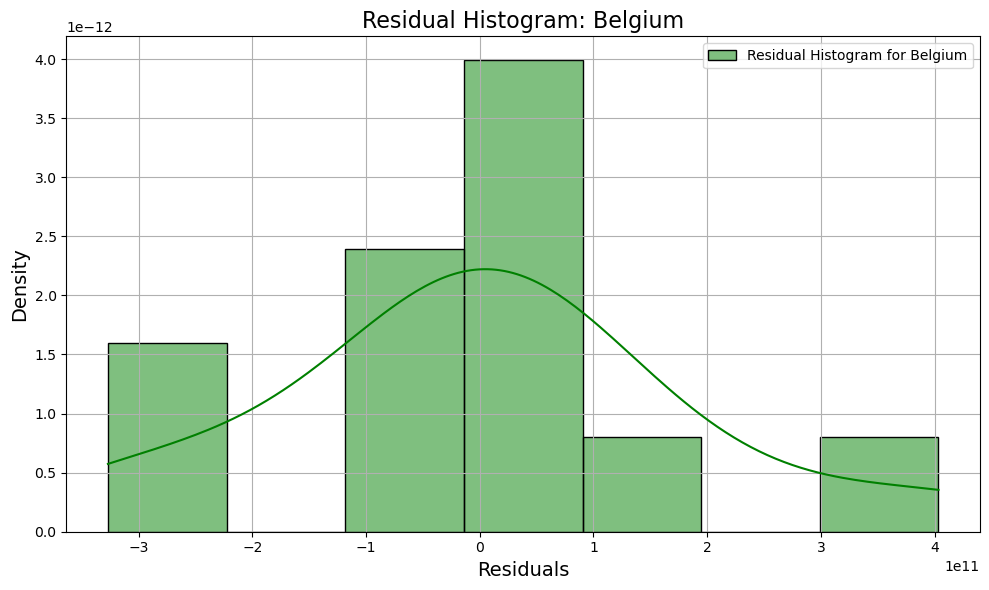

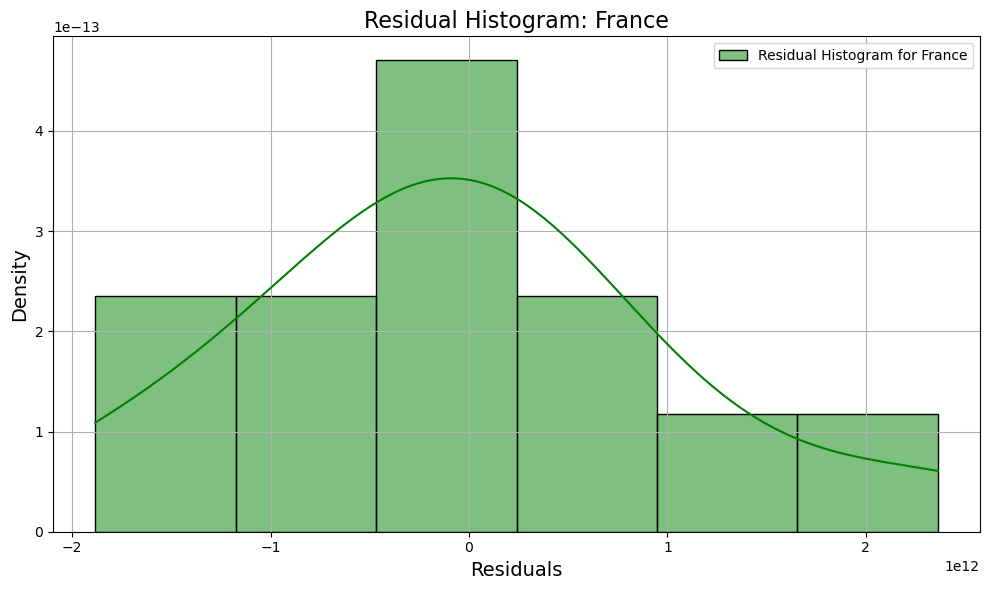

In [53]:
residuals = test_data - forecast_df

def plot_residual_series_2(residuals):
    for col in residuals.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(residuals.index, residuals[col], label=f'Residuals for {col}', color='green', marker='o', linestyle='-')
        plt.title(f'Residual Time Series: {col}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Residuals', fontsize=14)
        plt.legend(loc="upper left")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_residual_acf_2(residuals, lags=20):
    for col in residuals.columns:
        lags_for_col = min(lags, len(residuals[col].dropna()) - 1)
        
        plt.figure(figsize=(10, 6))
        plot_acf(residuals[col].dropna(), lags=lags_for_col)
        plt.title(f'Autocorrelation Function (ACF): {col}', fontsize=16)
        plt.xlabel('Lags', fontsize=14)
        plt.ylabel('ACF', fontsize=14)
        plt.tight_layout()
        plt.show()

def plot_residual_distribution_2(residuals):
    for col in residuals.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals[col], kde=True, stat='density', label=f'Residual Histogram for {col}', color='green')
        plt.title(f'Residual Histogram: {col}', fontsize=16)
        plt.xlabel('Residuals', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
plot_residual_series_2(residuals)
plot_residual_acf_2(residuals)
plot_residual_distribution_2(residuals)

TIme to do the model's performance overview: Evaluation metrics MAE and RMSE for France is much larger than for Austria and Belgium, which could indicate that model could not capture the dynamics ofr France unlike the other two countries. The model captures both own-country and cross-country GDP effects. Significant lagged terms p < 0.05 include L5, L6, L7, and L9 for Austria and Belgium, while France shows fewer but notable effects at L5 and L6. Cross-country lags suggest clear economic interdependencies. Time series plots for residuals show that exhibit more variance for France, but also for other two countries too, which indicates that model capturesn trends reasonably but struggles with certain period largs, particularly for France. ACF plots say that VAR model does not fully account for all temporal dependencies in the data, higher lag order or additional exogenous variables might improve performance. The residual histograms show an approximately symmetric shape for Austria and Belgium but more variability in France's residuals. This asymmetry and increased spread for France suggest that the model's errors are less well-distributed, indicating potential room for improvement when predicting France GDP. The residuals are highly correlated across the three countries, which suggests strong interdependencies remain across the residual series, which the model does not fully isolate. Ultimately, VAR model provides a useful framework for analyzing GDP dynamics in Austria, Belgium, and France, capturing significant cross-country relationships and long-term dependencies. However, its performance is uneven, with weaker forecasting accuracy for France.

Let's now make the ultimate comparison of all three models and rank them from best to worst based on their performance.

- **ARIMAX**(Winner):
With the lowest RMSE and MAE values, ARIMAX demonstrates superior predictive performance. The model effectively incorporates economic exogenous variables and successfully captures residual correlations. While it shows some weaknesses in residual normality and autoregressive influence, it provides the most accurate forecasts among the three models.

- **VAR**(Second):
Despite higher error metrics for individual countries, VAR offers valuable insights into cross-country economic relationships. It performs reasonably well for Austria and Belgium but struggles significantly with France. Its ability to capture economic interdependencies makes it useful for multi-country analysis, though less accurate than ARIMAX for pure forecasting.

- **Prophet**(Third):
With substantially higher error metrics than ARIMAX and clear evidence of systematic bias, Prophet demonstrates the weakest performance. The temporal patterns in residuals and significant autocorrelation suggest the model fails to capture important underlying dynamics in the GDP data.